In [12]:
import numpy as np 
from matplotlib import pyplot as plt
from tqdm import trange
from matplotlib.animation import FuncAnimation
import os 
import cv2

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import imageio.v2 as imageio
from tqdm import trange


In [13]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

(350, 900)
<class 'numpy.ndarray'> bool


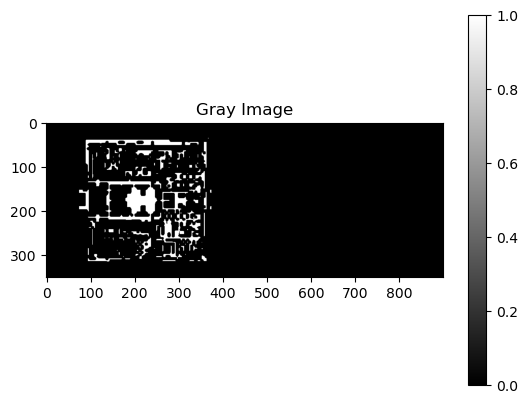

In [14]:
target_size = (350,900)
resize_size = (300,300)


data = np.load(r"..\dataset\all_cases.npz")["CN-BE-V1_d00"][0]
data = cv2.resize(data, resize_size, interpolation=cv2.INTER_LINEAR)
data = 1-data

target = np.zeros([target_size[0], target_size[1]])
# 計算放置位置 (簡單放在左上角)
placex =(target_size[1]//4) -(resize_size[1]//2)
placey =(target_size[0] -resize_size[0])//2
h, w = data.shape
target[placey : placey + resize_size[0], placex: placex + resize_size[1]] = data[:,:]


target = target > 0.5 
# 查看有哪些 key
print(target.shape)
print(type(target), target.dtype)
plt.imshow(target, cmap="gray")
plt.colorbar()
plt.title("Gray Image")
plt.show()

In [ ]:
def run_LBM():
    # --- 模擬參數 ---
    Nx = 400         # 格點數 (x 方向)
    Ny = 200         # 格點數 (y 方向)
    tau = 0.63       # 碰撞弛豫時間
    Nt = 60000       # 總模擬步數
    plot_every = 50  # 每幾步儲存一次畫面

    # --- 建立暫存資料夾 ---
    temp_dir = "temp_frames"
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    # --- LBM D2Q9 模型 ---
    NL = 9
    cxs = np.array([0,0,1,1,1,0,-1,-1,-1])
    cys = np.array([0,1,1,0,-1,-1,-1,0,1])
    weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36])

    # 初始分布函數
    F = np.ones([Ny, Nx, NL]) + 0.01*np.random.randn(Ny, Nx, NL)
    F[:,:,3] = 2.3

    # 固定障礙物 (圓柱)
    cylinder = np.full((Ny, Nx), False)
    for y in range(Ny):
        for x in range(Nx):
            if distance(Nx//4, Ny//2, x, y) < 13:
                cylinder[y, x] = True

    frame_id = 0

    # --- 主迴圈 ---
    for it in trange(Nt):
        # (1) Streaming
        for i, cx, cy in zip(range(NL), cxs, cys):
            F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
            F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)

        # (2) Bounce-back
        bndryF = F[cylinder,:]
        bndryF = bndryF[:, [0,5,6,7,8,1,2,3,4]]
        F[cylinder,:] = bndryF

        # (3) 宏觀量
        rho = np.sum(F, 2)
        ux  = np.sum(F*cxs, 2) / rho
        uy  = np.sum(F*cys, 2) / rho
        ux[cylinder] = 0
        uy[cylinder] = 0

        # (4) Collision
        Feq = np.zeros_like(F)
        for i, cx, cy, w in zip(range(NL), cxs, cys, weights):
            cu = cx*ux + cy*uy
            u2 = ux**2 + uy**2
            Feq[:,:,i] = rho * w * (1 + 3*cu + 4.5*cu**2 - 1.5*u2)
        F += -(1/tau) * (F - Feq)

        # (5) 存圖片
        if (it % plot_every) == 0 and it > 7000:
            vel = np.sqrt(ux**2 + uy**2)
            plt.imshow(vel, cmap="jet")
            plt.axis("off")
            plt.tight_layout()
            plt.savefig(f"{temp_dir}/frame_{frame_id:05d}.png", dpi=150)
            plt.close()
            frame_id += 1



In [18]:
import os
import imageio.v2 as imageio

def pngs_to_mp4(folder, output_file="output.mp4", fps=20):
    """
    將指定資料夾內的 PNG 圖片依序讀取並轉換為 MP4 影片

    Args:
        folder (str): PNG 圖片所在的資料夾
        output_file (str): 輸出影片檔名 (預設: output.mp4)
        fps (int): 影片的播放幀率 (預設: 20)
    """
    # 找出所有 png
    files = sorted(
        [f for f in os.listdir(folder) if f.endswith(".png")]
    )
    if not files:
        raise ValueError("資料夾裡沒有 PNG 檔案")

    # 讀取圖片
    images = []
    for f in files:
        path = os.path.join(folder, f)
        images.append(imageio.imread(path))

    # 存成 mp4
    imageio.mimsave(output_file, images, fps=fps)
    print(f"已輸出影片: {output_file}, 共 {len(images)} 幀")

# 假設模擬結果存在 temp_frames 資料夾
pngs_to_mp4("temp_frames", "lbm.mp4", fps=20)


已輸出影片: lbm.mp4, 共 1059 幀


In [20]:
import os
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

def pngs_to_mp4(folder, output_file="output.mp4", fps=20, save_avg=True, avg_file="avg.png"):
    """
    將指定資料夾內的 PNG 圖片依序讀取並轉換為 MP4 影片
    並可額外輸出所有幀的平均圖像

    Args:
        folder (str): PNG 圖片所在的資料夾
        output_file (str): 輸出影片檔名 (預設: output.mp4)
        fps (int): 影片的播放幀率 (預設: 20)
        save_avg (bool): 是否輸出平均圖 (預設: True)
        avg_file (str): 平均圖檔名 (預設: avg.png)
    """
    # 找出所有 png
    files = sorted([f for f in os.listdir(folder) if f.endswith(".png")])
    if not files:
        raise ValueError("資料夾裡沒有 PNG 檔案")

    images = []
    avg_accum = None  # 累積用

    for f in files:
        path = os.path.join(folder, f)
        img = imageio.imread(path).astype(np.float32)

        # 累加影像
        if avg_accum is None:
            avg_accum = np.zeros_like(img, dtype=np.float64)
        avg_accum += img

        images.append(img.astype(np.uint8))

    # 存成 mp4
    imageio.mimsave(output_file, images, fps=fps)
    print(f"已輸出影片: {output_file}, 共 {len(images)} 幀")

    # 輸出平均圖
    if save_avg:
        avg_img = (avg_accum / len(images)).astype(np.uint8)
        plt.imshow(avg_img, cmap="jet")
        plt.colorbar()
        plt.title("Average of all frames")
        plt.savefig(avg_file, dpi=200)
        plt.close()
        print(f"已輸出平均圖: {avg_file}")


pngs_to_mp4("temp_frames", "lbm.mp4", fps=20, save_avg=True, avg_file="lbm_avg.png")



已輸出影片: lbm.mp4, 共 1059 幀
已輸出平均圖: lbm_avg.png


In [17]:
run_LBM()

100%|██████████| 60000/60000 [22:17<00:00, 44.85it/s]
